In [1]:
import pandas as pd
import numpy as n
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import countDistinct, col, sum, when, coalesce, lit, date_format, to_timestamp, hour, dayofweek
from pyspark.sql import functions as F


In [2]:
!pip install pyspark

In [3]:
# Import Spark Session #
from pyspark.sql import SparkSession

In [4]:
# Start Spark Connection #
spark = SparkSession.builder.appName('ALY6110Project').getOrCreate()

23/06/30 12:45:28 WARN Utils: Your hostname, Bhagyashris-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.4 instead (on interface en0)
23/06/30 12:45:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/06/30 12:45:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [9]:
spark

In [6]:
#Load data#

path ='/Users/bhagyashrikadam/Documents/NEU_ASSIGNMENTS/ALY6110/Final Project/US_Accidents_March23.csv'
df_pyspark=spark.read.csv (path , header=True)

In [6]:
type(df_pyspark)

pyspark.sql.dataframe.DataFrame

In [7]:
num_rows = df_pyspark.count()
num_cols = len(df_pyspark.columns)

print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

Number of rows:  7728394
Number of columns:  46


In [13]:
df_pyspark.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: string (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: string (nullable = true)
 |-- Start_Lng: string (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance(mi): string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature(F): string (nullable = true)
 |-- Wind_Chill(F): string (nullable = true)
 |-- Humidity(%): string (nullable = true)
 |-- Pressure(in): string (nullable = true)
 |-- Visibility(

In [ ]:
df_pyspark.show(2)

In [9]:
# checking the head 10 records of the data #
df_pyspark.limit(10).toPandas().T

23/06/27 11:35:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0,1,2,3,4,5,6,7,8,9
ID,A-1,A-2,A-3,A-4,A-5,A-6,A-7,A-8,A-9,A-10
Source,Source2,Source2,Source2,Source2,Source2,Source2,Source2,Source2,Source2,Source2
Severity,3,2,2,3,2,3,2,3,2,3
Start_Time,2016-02-08 05:46:00,2016-02-08 06:07:59,2016-02-08 06:49:27,2016-02-08 07:23:34,2016-02-08 07:39:07,2016-02-08 07:44:26,2016-02-08 07:59:35,2016-02-08 07:59:58,2016-02-08 08:00:40,2016-02-08 08:10:04
End_Time,2016-02-08 11:00:00,2016-02-08 06:37:59,2016-02-08 07:19:27,2016-02-08 07:53:34,2016-02-08 08:09:07,2016-02-08 08:14:26,2016-02-08 08:29:35,2016-02-08 08:29:58,2016-02-08 08:30:40,2016-02-08 08:40:04
Start_Lat,39.865147,39.92805900000001,39.063148,39.747753,39.627781,40.100590000000004,39.758274,39.770382,39.778061,40.100590000000004
Start_Lng,-84.058723,-82.831184,-84.032608,-84.20558199999998,-84.188354,-82.92519399999998,-84.23050699999997,-84.194901,-84.172005,-82.92519399999998
End_Lat,None,None,None,None,None,None,None,None,None,None
End_Lng,None,None,None,None,None,None,None,None,None,None
Distance(mi),0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.01,0.0,0.01


In [7]:
# Renaming columns #

# Create the mapping dictionary
mapping = {
    "Visibility(mi)": "Visibility",
    "Wind_Speed(mph)": "Wind_Speed",
    "Distance(mi)" :  "Distance",
    "Temperature(F)" : "Temperature",
    "Wind_Chill(F)" :  "Wind_Chill",
    "Humidity(%)" :"Humidity",
    "Pressure(in)" :"Pressure",
     "Visibility(mi)" : "Visibility",
    "Wind_Speed(mph)" : "Wind_Speed",
    "Precipitation(in)" : "Precipitation"
    
}


# Select and rename columns using the mapping dictionary
df_pyspark = df_pyspark.select([col(c).alias(mapping.get(c, c)) for c in df_pyspark.columns])

In [8]:
# Extracting the year from the timestamp

from pyspark.sql.functions import year


# Assuming 'df' is the DataFrame containing the 'Weather_Timestamp' column
df_pyspark = df_pyspark.withColumn('Year', year(df_pyspark['Weather_Timestamp']))


In [8]:
# Calculate the count of missing values for each column
missing_values = df_pyspark.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in df_pyspark.columns])


# Convert the result to a Pandas DataFrame
df_missing_values = pd.DataFrame(missing_values.first().asDict().items(), columns=["Column", "Missing_Values"])
df_missing_values


23/06/28 13:10:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,Column,Missing_Values
0,ID,0
1,Source,0
2,Severity,0
3,Start_Time,0
4,End_Time,0
5,Start_Lat,0
6,Start_Lng,0
7,End_Lat,3402762
8,End_Lng,3402762
9,Distance,0


In [9]:
# Specify the columns with missing values and then remove them

columns_with_missing = ["City", "Zipcode", "Weather_Condition" ,"Temperature", "Humidity", "Pressure",
                        "Visibility", "Wind_Speed", "Year" , "Sunrise_Sunset" ,"Civil_Twilight" ,
                        "Nautical_Twilight" , "Astronomical_Twilight" ]


# Remove rows with missing values in specified columns
df_pyspark_clean = df_pyspark.dropna(subset=columns_with_missing)

In [10]:
# Replacing missing values for Precipitation with 0#

df_pyspark_clean = df_pyspark_clean.withColumn('Precipitation', when(df_pyspark_clean.Precipitation.isNull(), 0).otherwise(df_pyspark_clean.Precipitation))


In [11]:
# Replacing missing values for Description with "No comments"#

df_pyspark_clean = df_pyspark_clean.withColumn('Description', when(df_pyspark_clean.Description.isNull(), "No Comments").otherwise(df_pyspark_clean.Description))

In [12]:
# Replacing missing values for street with "No street data"#

df_pyspark_clean = df_pyspark_clean.withColumn('Street', when(df_pyspark_clean.Street.isNull(), "No Street data").otherwise(df_pyspark_clean.Street))

In [13]:
# Calculate the count of missing values for each column AFTER CLEANING THE DATA #
missing_values_clean = df_pyspark_clean.select(*[sum(col(c).isNull().cast("int")).alias(c) for c in df_pyspark_clean.columns])


# Convert the result to a Pandas DataFrame
df_missing_values_clean = pd.DataFrame(missing_values_clean.first().asDict().items(), columns=["Column", "Missing_Values"])
df_missing_values_clean


23/06/30 12:52:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,Column,Missing_Values
0,ID,0
1,Source,0
2,Severity,0
3,Start_Time,0
4,End_Time,0
5,Start_Lat,0
6,Start_Lng,0
7,End_Lat,3008470
8,End_Lng,3008470
9,Distance,0


In [14]:
# Drop column ID
df_pyspark_clean = df_pyspark_clean.drop("ID")


In [13]:
# Checking total no of records for cleaned dataset#

df_pyspark_clean.count()

7061839

In [17]:
# checking the statistical info for each numerical column #

df_pyspark_clean.describe("Severity","Distance","Temperature","Humidity","Pressure","Visibility","Wind_Speed","Precipitation").show()

+-------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|summary|           Severity|          Distance|      Temperature|          Humidity|          Pressure|        Visibility|        Wind_Speed|      Precipitation|
+-------+-------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|  count|            7061839|           7061839|          7061839|           7061839|           7061839|           7061839|           7061839|            7061839|
|   mean|  2.202510422568399|0.5686278966535171|61.86914963651785| 64.41364154577866| 29.51408396169856| 9.106960303116535|    7.691038623226|0.00590666963661951|
| stddev|0.48026413786068817| 1.763447440866646| 19.0415499151011|22.758765030268385|1.0152123045265642|2.6418818161984317|5.4133171640463935|0.07482367052713206|
|    min|             

In [15]:

from pyspark.sql.functions import to_timestamp, date_format, col

df_pyspark_clean = df_pyspark_clean.withColumn("Start_Time", to_timestamp(col("Start_Time")))
df_pyspark_clean = df_pyspark_clean.withColumn("month_of_year", date_format(col("Start_Time"), "MMMM"))
df_pyspark_clean = df_pyspark_clean.withColumn("day_of_week", date_format(col("Start_Time"), "EEEE"))
df_pyspark_clean = df_pyspark_clean.withColumn("hour_day", date_format(col("Start_Time"), "H"))


In [15]:
df_pyspark_clean.printSchema()

root
 |-- Source: string (nullable = true)
 |-- Severity: string (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: string (nullable = true)
 |-- Start_Lat: string (nullable = true)
 |-- Start_Lng: string (nullable = true)
 |-- End_Lat: string (nullable = true)
 |-- End_Lng: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Wind_Chill: string (nullable = true)
 |-- Humidity: string (nullable = true)
 |-- Pressure: string (nullable = true)
 |-- Visibility: string (nullable = true)
 |-- Wind_Direction: s

In [25]:
# checking the head 10 records of the data #
df_pyspark_clean.limit(10).toPandas().T

,0,1,2,3,4,5,6,7,8,9
Source,Source2,Source2,Source2,Source2,Source2,Source2,Source2,Source2,Source2,Source2
Severity,2,3,2,3,2,3,2,3,3,3
Start_Time,2016-02-08 06:49:27,2016-02-08 07:23:34,2016-02-08 07:39:07,2016-02-08 07:44:26,2016-02-08 07:59:35,2016-02-08 07:59:58,2016-02-08 08:00:40,2016-02-08 08:10:04,2016-02-08 08:14:42,2016-02-08 08:21:27
End_Time,2016-02-08 07:19:27,2016-02-08 07:53:34,2016-02-08 08:09:07,2016-02-08 08:14:26,2016-02-08 08:29:35,2016-02-08 08:29:58,2016-02-08 08:30:40,2016-02-08 08:40:04,2016-02-08 08:44:42,2016-02-08 08:51:27
Start_Lat,39.063148,39.747753,39.627781,40.100590000000004,39.758274,39.770382,39.778061,40.100590000000004,39.952812,39.932709
Start_Lng,-84.032608,-84.20558199999998,-84.188354,-82.92519399999998,-84.23050699999997,-84.194901,-84.172005,-82.92519399999998,-83.119293,-82.83091
End_Lat,None,None,None,None,None,None,None,None,None,None
End_Lng,None,None,None,None,None,None,None,None,None,None
Distance,0.01,0.01,0.01,0.01,0.0,0.01,0.0,0.01,0.01,0.01
Description,Accident on OH-32 State Route 32 Westbound at ...,Accident on I-75 Southbound at Exits 52 52B US...,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Accident on I-270 Outerbelt Northbound near Ex...,Accident on Oakridge Dr at Woodward Ave. Expec...,Accident on I-75 Southbound at Exit 54B Grand ...,Accident on Notre Dame Ave at Warner Ave. Expe...,Right hand shoulder blocked due to accident on...,Accident on I-270 Outerbelt Northbound at Exit...,One lane blocked due to accident on I-70 Westb...


In [16]:
from pyspark.sql.functions import year, month, hour, dayofweek

# Subset the data based on the year
data_2016 = df_pyspark_clean.filter(year('Start_Time') == 2016)
data_2017 = df_pyspark_clean.filter(year('Start_Time') == 2017)
data_2018 = df_pyspark_clean.filter(year('Start_Time') == 2018)
data_2019 = df_pyspark_clean.filter(year('Start_Time') == 2019)
data_2020 = df_pyspark_clean.filter(year('Start_Time') == 2020)
data_2021 = df_pyspark_clean.filter(year('Start_Time') == 2021)
data_2022 = df_pyspark_clean.filter(year('Start_Time') == 2022)
data_2023 = df_pyspark_clean.filter(year('Start_Time') == 2023)

In [18]:
data_2016.limit(10).toPandas().T

,0,1,2,3,4,5,6,7,8,9
Source,Source2,Source2,Source2,Source2,Source2,Source2,Source2,Source2,Source2,Source2
Severity,2,3,2,3,2,3,2,3,3,3
Start_Time,2016-02-08 06:49:27,2016-02-08 07:23:34,2016-02-08 07:39:07,2016-02-08 07:44:26,2016-02-08 07:59:35,2016-02-08 07:59:58,2016-02-08 08:00:40,2016-02-08 08:10:04,2016-02-08 08:14:42,2016-02-08 08:21:27
End_Time,2016-02-08 07:19:27,2016-02-08 07:53:34,2016-02-08 08:09:07,2016-02-08 08:14:26,2016-02-08 08:29:35,2016-02-08 08:29:58,2016-02-08 08:30:40,2016-02-08 08:40:04,2016-02-08 08:44:42,2016-02-08 08:51:27
Start_Lat,39.063148,39.747753,39.627781,40.100590000000004,39.758274,39.770382,39.778061,40.100590000000004,39.952812,39.932709
Start_Lng,-84.032608,-84.20558199999998,-84.188354,-82.92519399999998,-84.23050699999997,-84.194901,-84.172005,-82.92519399999998,-83.119293,-82.83091
End_Lat,None,None,None,None,None,None,None,None,None,None
End_Lng,None,None,None,None,None,None,None,None,None,None
Distance,0.01,0.01,0.01,0.01,0.0,0.01,0.0,0.01,0.01,0.01
Description,Accident on OH-32 State Route 32 Westbound at ...,Accident on I-75 Southbound at Exits 52 52B US...,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Accident on I-270 Outerbelt Northbound near Ex...,Accident on Oakridge Dr at Woodward Ave. Expec...,Accident on I-75 Southbound at Exit 54B Grand ...,Accident on Notre Dame Ave at Warner Ave. Expe...,Right hand shoulder blocked due to accident on...,Accident on I-270 Outerbelt Northbound at Exit...,One lane blocked due to accident on I-70 Westb...


In [17]:
# Execute the SQL query for showin the total accidents by Year #
# Register the table as a temporary view

df_pyspark_clean.createOrReplaceTempView("accidents_year")

acc_year = spark.sql("SELECT Year, COUNT(*) AS Accidents FROM accidents_year WHERE Year IS NOT NULL GROUP BY Year ORDER BY Year")

# Show the results
acc_year.show()

+----+---------+
|Year|Accidents|
+----+---------+
|2016|   328560|
|2017|   576417|
|2018|   716816|
|2019|   886890|
|2020|  1131530|
|2021|  1504781|
|2022|  1681540|
|2023|   235305|
+----+---------+



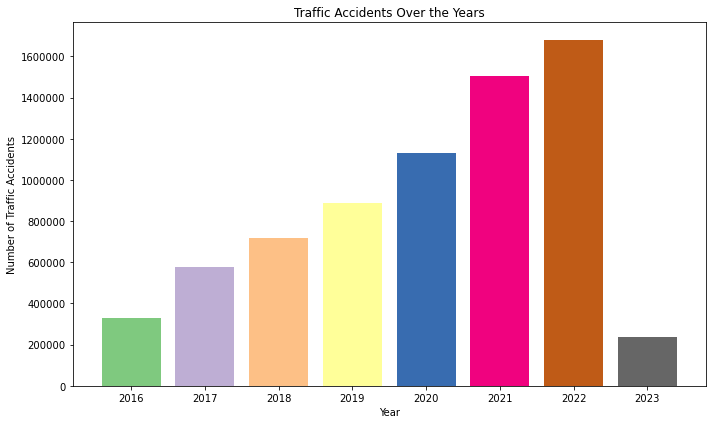

In [16]:
## Bar plot for accidents over the years ##

# Convert the results to a Pandas DataFrame
from matplotlib import ticker

results_pd = acc_year.toPandas()

# Define the "tab10" color palette
color_palette = plt.get_cmap("Accent").colors

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(results_pd["Year"], results_pd["Accidents"], color=color_palette)
plt.xlabel("Year")
plt.ylabel("Number of Traffic Accidents")
plt.title("Traffic Accidents Over the Years")
plt.xticks(results_pd["Year"], results_pd["Year"].astype(str))  # Set x-axis labels as the full year and rotate them by 45 degrees
plt.ticklabel_format(style='plain', axis='y')  # Display y-axis labels as actual values
plt.tight_layout()
plt.style.use("seaborn-talk")
plt.show()

In [ ]:
# Checking different styles for plots ##

print(plt.style.available)


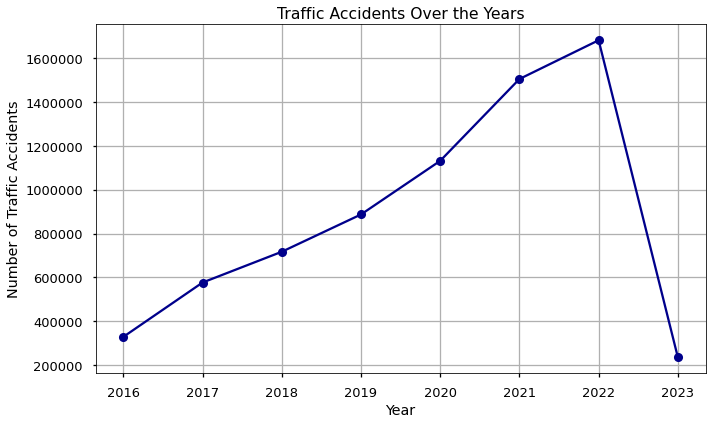

In [17]:
### TRAFFIC ACCIDENTS OVER THE YEARS -- NORMAL LINEGRAPH ##
plt.figure(figsize=(10, 6))
plt.plot(results_pd["Year"], results_pd["Accidents"], marker='o', linestyle='-', color='darkblue')
plt.xlabel("Year")
plt.ylabel("Number of Traffic Accidents")
plt.title("Traffic Accidents Over the Years")
plt.style.use("seaborn-talk")
plt.xticks(results_pd["Year"], results_pd["Year"].astype(str))  # Set x-axis labels as the full year and rotate them by 45 degrees
plt.ticklabel_format(style='plain', axis='y')  # Display y-axis labels as actual values
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
### TRAFFIC ACCIDENTS OVER THE YEARS -- PLOTLY LINEGRAPH ##

import plotly.graph_objects as go

# Create a line graph
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=results_pd["Year"],
    y=results_pd["Accidents"],
    mode='lines+markers',
    name='Number of Traffic Accidents',
    line=dict(color='darkblue', width=2),
    marker=dict(symbol='circle', size=6, color='darkblue')
))

fig.update_layout(
    title="Traffic Accidents Over the Years",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Number of Traffic Accidents"),
    showlegend=True,
    plot_bgcolor='rgba(0, 0, 0, 0)'  # Set plot background color to transparent
)

fig.show()


In [31]:
## SCATTERPLOT - TEMPERATURE VS NUMBER OF ACCIDENTS ##

temperature = spark.sql("SELECT Temperature, COUNT(*) AS Accidents\
                         FROM accidents_year \
                         GROUP BY Temperature\
                         ORDER BY Accidents DESC").limit(10)
temperature.show()

+-----------+---------+
|Temperature|Accidents|
+-----------+---------+
|       73.0|   162918|
|       77.0|   160945|
|       72.0|   152935|
|       68.0|   152060|
|       75.0|   151172|
|       70.0|   147557|
|       63.0|   141836|
|       79.0|   141365|
|       64.0|   140146|
|       66.0|   137114|
+-----------+---------+



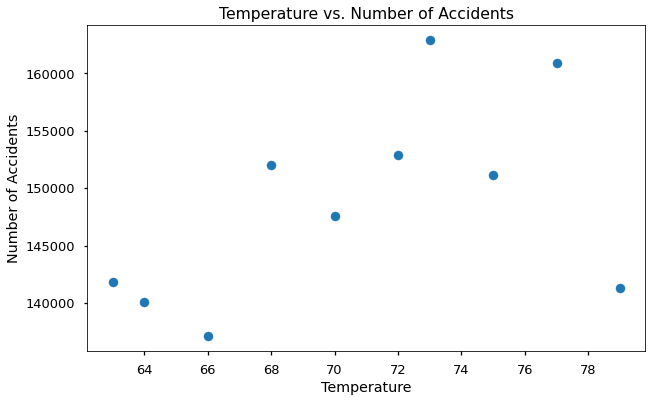

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import FloatType


# Convert the "Temperature" column to float type
temperature_accidents = temperature.withColumn("Temperature", col("Temperature").cast(FloatType()))

# Filter out null values
filtered_data = temperature_accidents.filter(col("Temperature").isNotNull())

# Convert PySpark DataFrame to Pandas DataFrame
pandas_data = filtered_data.toPandas()

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(pandas_data["Temperature"], pandas_data["Accidents"])
plt.xlabel("Temperature")
plt.ylabel("Number of Accidents")
plt.title("Temperature vs. Number of Accidents")
plt.ticklabel_format(style='plain', axis='y')  # Display y-axis labels as actual values

plt.show()


In [33]:
# Selecting the relevant columns for correlation analysis #

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

selected_columns = ["Severity","Distance","Temperature","Humidity","Pressure","Visibility","Wind_Speed","Precipitation"]
selected_df = df_pyspark_clean.select(*selected_columns)

numeric_df = selected_df.select([col(column).cast("double").alias(column) for column in selected_df.columns])

vector_assembler = VectorAssembler(inputCols=numeric_df.columns, outputCol="features")
assembled_df = vector_assembler.transform(numeric_df).select("features")

correlation_matrix = Correlation.corr(assembled_df, "features").head()
correlation_values = correlation_matrix[0].toArray().tolist()
correlation_df = pd.DataFrame(correlation_values, columns=numeric_df.columns, index=numeric_df.columns)

# correlation matrix
print(correlation_df)

23/06/27 11:41:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


               Severity  Distance  Temperature  Humidity  Pressure  \
Severity       1.000000  0.033233    -0.017893  0.016255  0.034418   
Distance       0.033233  1.000000    -0.055947  0.011414 -0.090331   
Temperature   -0.017893 -0.055947     1.000000 -0.330525  0.120096   
Humidity       0.016255  0.011414    -0.330525  1.000000  0.109955   
Pressure       0.034418 -0.090331     0.120096  0.109955  1.000000   
Visibility    -0.002347 -0.039519     0.224068 -0.386863  0.041189   
Wind_Speed     0.040217  0.008749     0.034661 -0.172697 -0.022330   
Precipitation  0.011096  0.003166    -0.004006  0.088178  0.003794   

               Visibility  Wind_Speed  Precipitation  
Severity        -0.002347    0.040217       0.011096  
Distance        -0.039519    0.008749       0.003166  
Temperature      0.224068    0.034661      -0.004006  
Humidity        -0.386863   -0.172697       0.088178  
Pressure         0.041189   -0.022330       0.003794  
Visibility       1.000000    0.014533  

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
## HISTOGRAM ##

# Remove NA values from DataFrame
selected_df = selected_df.dropna()

# Plot distribution of features
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment="center")
for col, num in zip(selected_df.columns, range(1, 20)):
    ax = fig.add_subplot(5, 3, num)
    ax.hist(selected_df.select(col).toPandas()[col])
    plt.grid(False)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=20)
    plt.xticks([])

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [34]:
### ARCHIT's CODE ###

from pyspark.sql.functions import count

# Group the data by state and count the number of accidents
state_counts = df_pyspark_clean.groupBy('State').agg(count('*').alias('Accident_Count'))

# Order the results by state
state_counts = state_counts.orderBy('State')

# Show the result
state_counts.show()

+-----+--------------+
|State|Accident_Count|
+-----+--------------+
|   AL|         94250|
|   AR|         21033|
|   AZ|        153854|
|   CA|       1559811|
|   CO|         83534|
|   CT|         67755|
|   DC|         17251|
|   DE|         13614|
|   FL|        830830|
|   GA|        151585|
|   IA|         24278|
|   ID|          9866|
|   IL|        161831|
|   IN|         62013|
|   KS|         17849|
|   KY|         29901|
|   LA|        141882|
|   MA|         55983|
|   MD|        103543|
|   ME|          2444|
+-----+--------------+
only showing top 20 rows



In [35]:
from pyspark.sql.functions import count

# Group the data by state and count the number of accidents
state_counts = df_pyspark_clean.groupBy('State').agg(count('*').alias('Accident_Count'))

# Order the results by the number of accidents in descending order
state_counts = state_counts.orderBy('Accident_Count', ascending=False)

# Show the top 10 states
state_counts.show(10)

+-----+--------------+
|State|Accident_Count|
+-----+--------------+
|   CA|       1559811|
|   FL|        830830|
|   TX|        537045|
|   SC|        348798|
|   NY|        326479|
|   NC|        309545|
|   PA|        269875|
|   VA|        268379|
|   MN|        181436|
|   OR|        165078|
+-----+--------------+
only showing top 10 rows



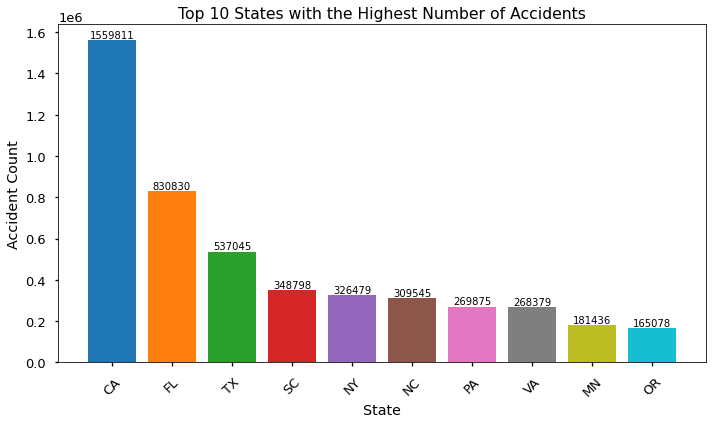

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the PySpark DataFrame to Pandas DataFrame
state_counts_pd = state_counts.toPandas()

# Select the top 10 states
top_10_states = state_counts_pd.head(10)

# Create a colormap for different colors for each state
colors = plt.cm.get_cmap('tab10', len(top_10_states))

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(top_10_states['State'], top_10_states['Accident_Count'],color=colors(range(len(top_10_states))))
plt.xlabel('State')
plt.ylabel('Accident Count')
plt.title('Top 10 States with the Highest Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()


# Add labels for each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom')

plt.show()


In [19]:
## TRAFFIC ACCIDENTS BY MONTH ## 

from pyspark.sql.functions import month
from pyspark.sql.types import StringType
import calendar

# Compute the count of cases for each month
month_df = df_pyspark_clean.select(month('Start_Time').alias('Month')).groupBy('Month').count()

# Sort the DataFrame by the 'Month' column in ascending order
month_df = month_df.orderBy('Month')

# Create a UDF to map month numbers to month names
month_names = [calendar.month_name[i] for i in range(1, 13)]
month_names_udf = F.udf(lambda month_num: month_names[month_num - 1], StringType())

# Apply the UDF to convert month numbers to month names
month_df = month_df.withColumn('Month', month_names_udf('Month'))


In [20]:


import pandas as pd
import plotly.graph_objects as go
import calendar

# Convert the PySpark DataFrame to Pandas DataFrame for visualization
month_df_pd = month_df.toPandas()

# Define the colorscale
colorscale = 'plasma'

# Create the figure and configure the layout
fig = go.Figure()

# Add the bar trace
fig.add_trace(go.Bar(
    x=month_df_pd['count'],
    y=month_df_pd['Month'],
    orientation='h',
    marker=dict(
        color=month_df_pd['count'],
        colorscale=colorscale,
        cmin=month_df_pd['count'].min(),
        cmax=month_df_pd['count'].max(),
        colorbar=dict(
            title='Accident Cases'
        )
    )
))

# Configure the text annotations
total = month_df_pd['count'].sum()
for i, v in enumerate(month_df_pd['count']):
    fig.add_annotation(
        x=v,
        y=month_df_pd['Month'][i],
        text=f'{v/total*100:.2f}%',
        showarrow=False,
        font=dict(
            size=10,
            color='black'  # Adjust the font color for better visibility
        ),
        align='left',
        xshift=10
    )

# Configure the layout
fig.update_layout(
    title='\n Accident Percentage\nfor different months in US (2016-2023)\n',
    xaxis_title='\nAccident Cases\n',
    yaxis_title='\nMonths\n',
    xaxis=dict(
        tickmode='linear',
        dtick=50000,  # Adjust the tick interval to avoid cluttering
        range=[0, month_df_pd['count'].max() + 10000]  # Adjust the x-axis range
    ),
    plot_bgcolor='white',
    showlegend=False,
    height=600,  # Increase figure height for better visibility
    width=800  # Increase figure width for better visibility
)

# Show the figure
fig.show()


In [27]:
## TRAFFIC ACCIDENTS - WEEK ANALYSIS ##

import pyspark.sql.functions as F
import pandas as pd
import plotly.graph_objects as go
import calendar

# Compute the count of cases for each day
day_df = df_pyspark_clean.select(F.dayofweek('Start_Time').alias('Day')).groupBy('Day').count()

# Map day numbers to day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert 'Day' column to a categorical type with desired order
day_df = day_df.withColumn('Day', F.expr(f"cast(Day as string)").cast('string'))
day_df = day_df.withColumn('Day', F.when(F.col('Day') == '1', day_names[0])
                               .when(F.col('Day') == '2', day_names[1])
                               .when(F.col('Day') == '3', day_names[2])
                               .when(F.col('Day') == '4', day_names[3])
                               .when(F.col('Day') == '5', day_names[4])
                               .when(F.col('Day') == '6', day_names[5])
                               .when(F.col('Day') == '7', day_names[6]))

# Sort the DataFrame by the index of day names
day_df = day_df.toPandas().set_index('Day').loc[day_names].reset_index()

# Convert the PySpark DataFrame to Pandas DataFrame for visualization
day_df_pd = pd.DataFrame(day_df)

# Compute the total number of accident cases
total_cases = day_df_pd['count'].sum()

# Compute the percentage of accidents for each day
day_df_pd['Percentage'] = (day_df_pd['count'] / total_cases) * 100

# Define the colorscale
colorscale = 'plasma'

# Create the figure and configure the layout
fig = go.Figure()

# Add the bar trace
fig.add_trace(go.Bar(
    x=day_df_pd['Percentage'],
    y=day_df_pd['Day'],
    orientation='h',
    marker=dict(
        color=day_df_pd['Percentage'],
        colorscale=colorscale,
        cmin=day_df_pd['Percentage'].min(),
        cmax=day_df_pd['Percentage'].max(),
        colorbar=dict(
            title='Percentage'
        )
    )
))

# Configure the text annotations
for i, row in day_df_pd.iterrows():
    fig.add_annotation(
        x=row['Percentage'],
        y=row['Day'],
        text=f'{row["Percentage"]:.2f}%',
        showarrow=False,
        font=dict(
            size=12,
            color='black'  # Adjust the font color for better visibility
        ),
        align='left',
        xshift=10
    )

# Configure the layout
fig.update_layout(
    title='\nPercentage of Accidents\nby Day of the Week (2016-2023)\n',
    xaxis_title='\nPercentage of Accident Cases\n',
    yaxis_title='\nDay of the Week\n',
    xaxis=dict(
        tickmode='linear',
        dtick=5,  # Adjust the tick interval for the x-axis
        range=[0, day_df_pd['Percentage'].max() + 5]  # Adjust the x-axis range
    ),
    plot_bgcolor='white',
    showlegend=False,
    height=600,  # Increase figure height for better visibility
    width=800  # Increase figure width for better visibility
    )

# Show the figure
fig.show()


In [28]:
### WEEKDAY VS WEEKEND ANALYSIS ###

import pandas as pd
import plotly.graph_objects as go
import pyspark.sql.functions as F

# Compute the count of cases for weekdays and weekends
weekday_df = df_pyspark_clean.select(F.dayofweek('Start_Time').alias('Day')).groupBy('Day').count().filter(F.col('Day') < 7)
weekend_df = df_pyspark_clean.select(F.dayofweek('Start_Time').alias('Day')).groupBy('Day').count().filter(F.col('Day') >= 7)

# Compute the total number of weekday and weekend cases
total_weekday_cases = weekday_df.agg(F.sum('count')).collect()[0][0]
total_weekend_cases = weekend_df.agg(F.sum('count')).collect()[0][0]

# Compute the percentage of weekday and weekend cases
weekday_percentage = (total_weekday_cases / (total_weekday_cases + total_weekend_cases)) * 100
weekend_percentage = (total_weekend_cases / (total_weekday_cases + total_weekend_cases)) * 100

# Create the DataFrame for the pie chart
pie_df = pd.DataFrame({'Type': ['Weekday', 'Weekend'], 'Percentage': [weekday_percentage, weekend_percentage]})

# Create the pie chart
fig = go.Figure(data=[go.Pie(
    labels=pie_df['Type'],
    values=pie_df['Percentage'],
    pull=[0, 0.2],  # Pull the "Weekend" slice to create an exploded effect
    textinfo='label+percent',  # Display only the percentage values on the labels
    textfont=dict(size=12),
    marker=dict(
        colors=['#1f77b4', '#ff7f0e'],
        line=dict(color='#ffffff', width=2)
    ),
    hole=0.3  # Create a donut shape by setting the hole size
)])

# Configure the layout
fig.update_layout(
    title='\nPercentage of Accidents\nWeekday vs Weekend (2016-2023)\n',
    showlegend=False,
    height=600,  # Increase figure height for better visibility
    width=800  # Increase figure width for better visibility
)

# Show the figure
fig.show()


In [37]:
## TRAFFIC ACCIDENTS - HOURLY ANALYSIS ##

import pandas as pd
import pyspark.sql.functions as F

# Compute the count of cases for each hour
hour_df = df_pyspark_clean.select(F.hour('Start_Time').alias('Hours')).groupBy('Hours').count()

# Convert the PySpark DataFrame to Pandas DataFrame
hour_df_pd = hour_df.toPandas()

# Rename the columns
hour_df_pd = hour_df_pd.rename(columns={'Hours': 'Hours', 'count': 'Cases'})

# Sort the DataFrame by 'Hours' column
hour_df_pd = hour_df_pd.sort_values('Hours')


In [29]:
## TRAFFIC ACCIDENTS - HOURLY ANALYSIS - BARPLOT ##

import pandas as pd
import plotly.graph_objects as go
import pyspark.sql.functions as F

# Compute the count of cases for each hour
hour_df = df_pyspark_clean.select(F.hour('Start_Time').alias('Hours')).groupBy('Hours').count()

# Convert the PySpark DataFrame to Pandas DataFrame
hour_df_pd = hour_df.toPandas()

# Rename the columns
hour_df_pd = hour_df_pd.rename(columns={'Hours': 'Hours', 'count': 'Cases'})

# Calculate the total number of cases
total_cases = hour_df_pd['Cases'].sum()

# Calculate the percentage for each hour
hour_df_pd['Percentage'] = (hour_df_pd['Cases'] / total_cases) * 100

# Find the hour with the highest percentage
max_percentage_hour = hour_df_pd['Percentage'].idxmax()

# Create a color list for the bars
colors = ['#1f77b4'] * 24
colors[max_percentage_hour] = '#ff7f0e'  # Set a different color for the bar with the highest percentage

# Create the bar chart
fig = go.Figure(data=[go.Bar(
    x=hour_df_pd['Hours'],
    y=hour_df_pd['Cases'],
    text=hour_df_pd['Percentage'].apply(lambda x: f'{x:.2f}%'),
    textposition='auto',  # Display the text on the bars
   marker=dict(color=colors)  # Set the bar colors
    ## marker_color=sns.color_palette()  # Set the bar colors using the Seaborn palette

)])

# Configure the layout
fig.update_layout(
    title='\nAccident Percentage\nfor different hours along the day\n',
    xaxis=dict(
        tickmode='linear',
        tick0=0,  # Start the tick from 0
        dtick=1,  # Set the tick interval to 1
        range=[-0.5, 23.5],  # Set the x-axis range from -0.5 to 23.5
        tickfont=dict(size=10)  # Adjust the tick font size
    ),
    xaxis_title='\nHours\n',
    yaxis_title='\nAccident Cases\n',
    plot_bgcolor='white',
    showlegend=False,
    height=600,
    width=800
)

# Show the figure
fig.show()


In [30]:
## TRAFFIC ACCIDENTS - HOURLY ANALYSIS - AREAPLOT ##

import pandas as pd
import plotly.graph_objects as go
import pyspark.sql.functions as F

# Compute the count of cases for each hour
hour_df = df_pyspark_clean.select(F.hour('Start_Time').alias('Hours')).groupBy('Hours').count()

# Convert the PySpark DataFrame to Pandas DataFrame
hour_df_pd = hour_df.toPandas()

# Rename the columns
hour_df_pd = hour_df_pd.rename(columns={'Hours': 'Hours', 'count': 'Cases'})

# Sort the DataFrame by the 'Hours' column in ascending order
hour_df_pd = hour_df_pd.sort_values('Hours')

# Create the line plot
fig = go.Figure(data=go.Scatter(
    x=hour_df_pd['Hours'],
    y=hour_df_pd['Cases'],
    mode='lines',
    line=dict(color='#05ffda', width=2),
    fill='tozeroy'  # Fill the area below the line
))

# Configure the layout
fig.update_layout(
    title='\nAccident Distribution \nby Hour of the Day\n',
    xaxis=dict(
        tickmode='linear',
        tick0=0,  # Start the tick from 0
        dtick=1,  # Set the tick interval to 1
        range=[0, 23],  # Set the x-axis range from 0 to 23
        tickfont=dict(size=10)  # Adjust the tick font size
    ),
    xaxis_title='\nHours\n',
    yaxis_title='\nAccident Cases\n',
    plot_bgcolor='white',
    showlegend=False,
    height=600,
    width=800
)

# Show the figure
fig.show()


In [30]:
## NIKSHITA UPDATED ##

## TRAFFIC ACCIDENTS BY SEVERITY - 3D PIE CHART ##


from pyspark.sql.functions import count

# Group the data by severity and count the number of accidents
severity_counts = df_pyspark_clean.groupBy('Severity').agg(count('*').alias('Accident_Count'))

# Order the results by severity
severity_counts = severity_counts.orderBy('Severity')

# Show the result
severity_counts.show()


+--------+--------------+
|Severity|Accident_Count|
+--------+--------------+
|       1|         65178|
|       2|       5680385|
|       3|       1137278|
|       4|        178998|
+--------+--------------+



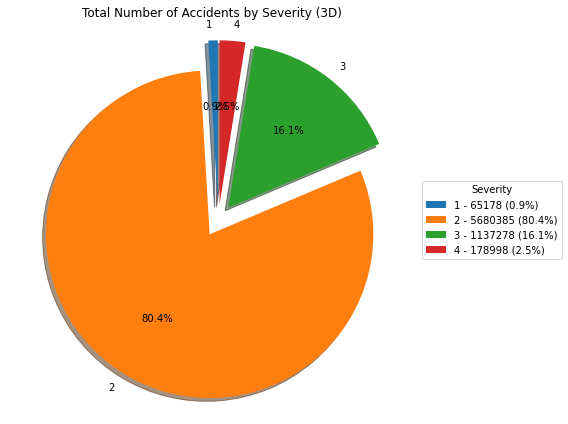

In [27]:
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to Pandas DataFrame
severity_counts_pd = severity_counts.toPandas()

# Create the 3D pie chart
plt.figure(figsize=(8, 6))
explode = [0.1] * len(severity_counts_pd)  # Optional: explode slices for emphasis

wedges, texts, autotexts = plt.pie(severity_counts_pd['Accident_Count'],
                                   labels=severity_counts_pd['Severity'],
                                   autopct='%1.1f%%',  # Display values as percentages on the chart
                                   startangle=90,
                                   explode=explode,
                                   shadow=True)

# Create the legend with labels and values
legend_labels = [f'{label} - {value} ({autotext.get_text()})' for label, value, autotext in
                 zip(severity_counts_pd['Severity'], severity_counts_pd['Accident_Count'], autotexts)]
plt.legend(wedges, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Severity')

# Adjust the layout
plt.axis('equal')
plt.title('Total Number of Accidents by Severity (3D)')
plt.tight_layout()  # Ensures the legend is displayed correctly
plt.show()


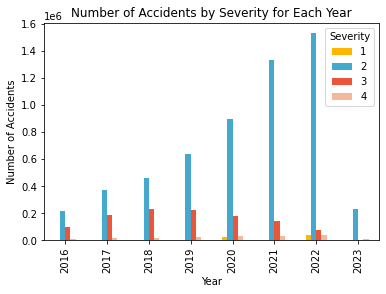

In [28]:
## TRAFFIC ACCIDENTS BY SEVERITY - BARPLOT ##


# Group the data by Year and Severity, and count the number of accidents
grouped_df = df_pyspark_clean.groupBy('Year', 'Severity').count().orderBy('Year')

# Convert the Spark DataFrame to Pandas DataFrame for plotting
pandas_df = grouped_df.toPandas()

# Pivot the data to have Severity values as columns
pivoted_df = pandas_df.pivot(index='Year', columns='Severity', values='count')

colors = ["#FFB600","#44A9CC","#EB563A","#F4B998"]
pivoted_df.plot(kind='bar', stacked=False, color=colors)

plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.title('Number of Accidents by Severity for Each Year')
plt.legend(title='Severity')

In [38]:
## NO OF TRAFFIC ACCIDENTS BY STATE - MAP ##

import plotly.graph_objects as go

# Perform the count aggregation using PySpark
state_count = df_pyspark_clean.groupBy('State').count().toPandas()

fig = go.Figure(data=go.Choropleth(
    locations=state_count['State'],
    z=state_count['count'].astype(float),
    locationmode='USA-states',
    colorscale='aggrnyl',
    colorbar_title="Count of Accidents",
))

fig.update_layout(
    title_text='No of US Accidents by State',
    geo_scope='usa',
)

fig.show()

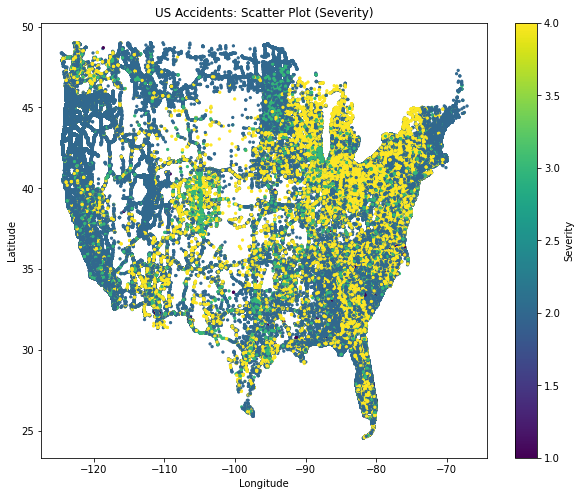

In [40]:
## NO OF TRAFFIC ACCIDENTS BY SEVERITY - DENSITY MAP ##

lat_lng_severity_df = df_pyspark_clean.select(
    col("Start_Lng").cast("float").alias("Longitude"),
    col("Start_Lat").cast("float").alias("Latitude"),
    col("Severity")
)

# Step 5: Convert to Pandas DataFrame
pandas_df = lat_lng_severity_df.toPandas()

# Step 6: Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(pandas_df["Longitude"], pandas_df["Latitude"], c=pandas_df["Severity"].astype(int), cmap="viridis",s=5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("US Accidents: Scatter Plot (Severity)")
plt.colorbar(label="Severity")
plt.show()

In [41]:
## ARCHIT UPDATED ##

## TRAFFIC ACCIDENTS FOR TOP 10 STATES WITH THEIR RESPECTIVE CITIES  ##


import plotly.graph_objects as go
import plotly.colors as colors

# Convert the PySpark DataFrame to Pandas DataFrame
state_counts_pd = df_pyspark_clean.groupBy('State', 'City').count().toPandas()

# Group by state and get the count for each city
state_city_counts = state_counts_pd.groupby('State')['count'].sum().reset_index()

# Select the top 10 states
top_10_states = state_city_counts.nlargest(10, 'count')

# Create a diverging color scale
color_scale = colors.diverging.RdYlBu

# Create the horizontal bar chart with color shade
fig = go.Figure()

# Add bars to the chart
for i, row in top_10_states.iterrows():
    bar_text = f"{row['State']} - {row['count']}<br>{state_counts_pd.loc[state_counts_pd['State'] == row['State'], 'City'].values[0]}"
    fig.add_trace(go.Bar(
        x=[row['count']],
        y=[row['State']],
        orientation='h',
        text=[bar_text],
        hovertemplate='%{text}',
        marker=dict(
            color=row['count'],
            colorscale=color_scale,
            line=dict(color='rgba(50, 171, 96, 1.0)', width=1)
        ),
        textposition='inside'
    ))

# Update layout properties
fig.update_layout(
    title='Top 10 States with the Highest Number of Accidents',
    xaxis_title='Accident Count',
    yaxis_title='State',
    yaxis=dict(autorange='reversed'),
    showlegend=False
)

# Show the horizontal bar chart
fig.show()


In [42]:
## TOTAL NUMBER OF ACCIDENTS BY SEVERITY (3D SCATTER PLOT)
import plotly.graph_objects as go

# Convert the PySpark DataFrame to Pandas DataFrame
severity_counts_pd = severity_counts.toPandas()

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=severity_counts_pd['Severity'],
    y=severity_counts_pd['Accident_Count'],
    z=[0] * len(severity_counts_pd),  # Z-values set to 0
    mode='markers',
    marker=dict(
        size=10,
        color=severity_counts_pd['Accident_Count'],
        colorscale='Viridis',
        opacity=0.8
    ),
    text=severity_counts_pd['Severity']
)])

# Update layout properties
fig.update_layout(title='Total Number of Accidents by Severity (3D Scatter Plot)',
                  scene=dict(xaxis_title='Severity', yaxis_title='Accident Count'))

# Show the 3D scatter plot
fig.show()



In [43]:
## TOTAL NUMBER OF ACCIDENTS BY SEVERITY (3D DONUT PIE CHART)


import plotly.express as px

# Convert the PySpark DataFrame to Pandas DataFrame
severity_counts_pd = severity_counts.toPandas()

# Create the 3D plot
fig = px.pie(severity_counts_pd, values='Accident_Count', names='Severity',
             title='Total Number of Accidents by Severity (3D)',
             hover_data=['Accident_Count'], labels={'Accident_Count': 'Count'})

# Add 3D effect to the pie chart
fig.update_traces(hole=0.4, hoverinfo='label+percent+name', textinfo='value+percent',
                  textfont_size=12, marker=dict(colors=px.colors.sequential.RdBu))

# Show the 3D plot
fig.show()


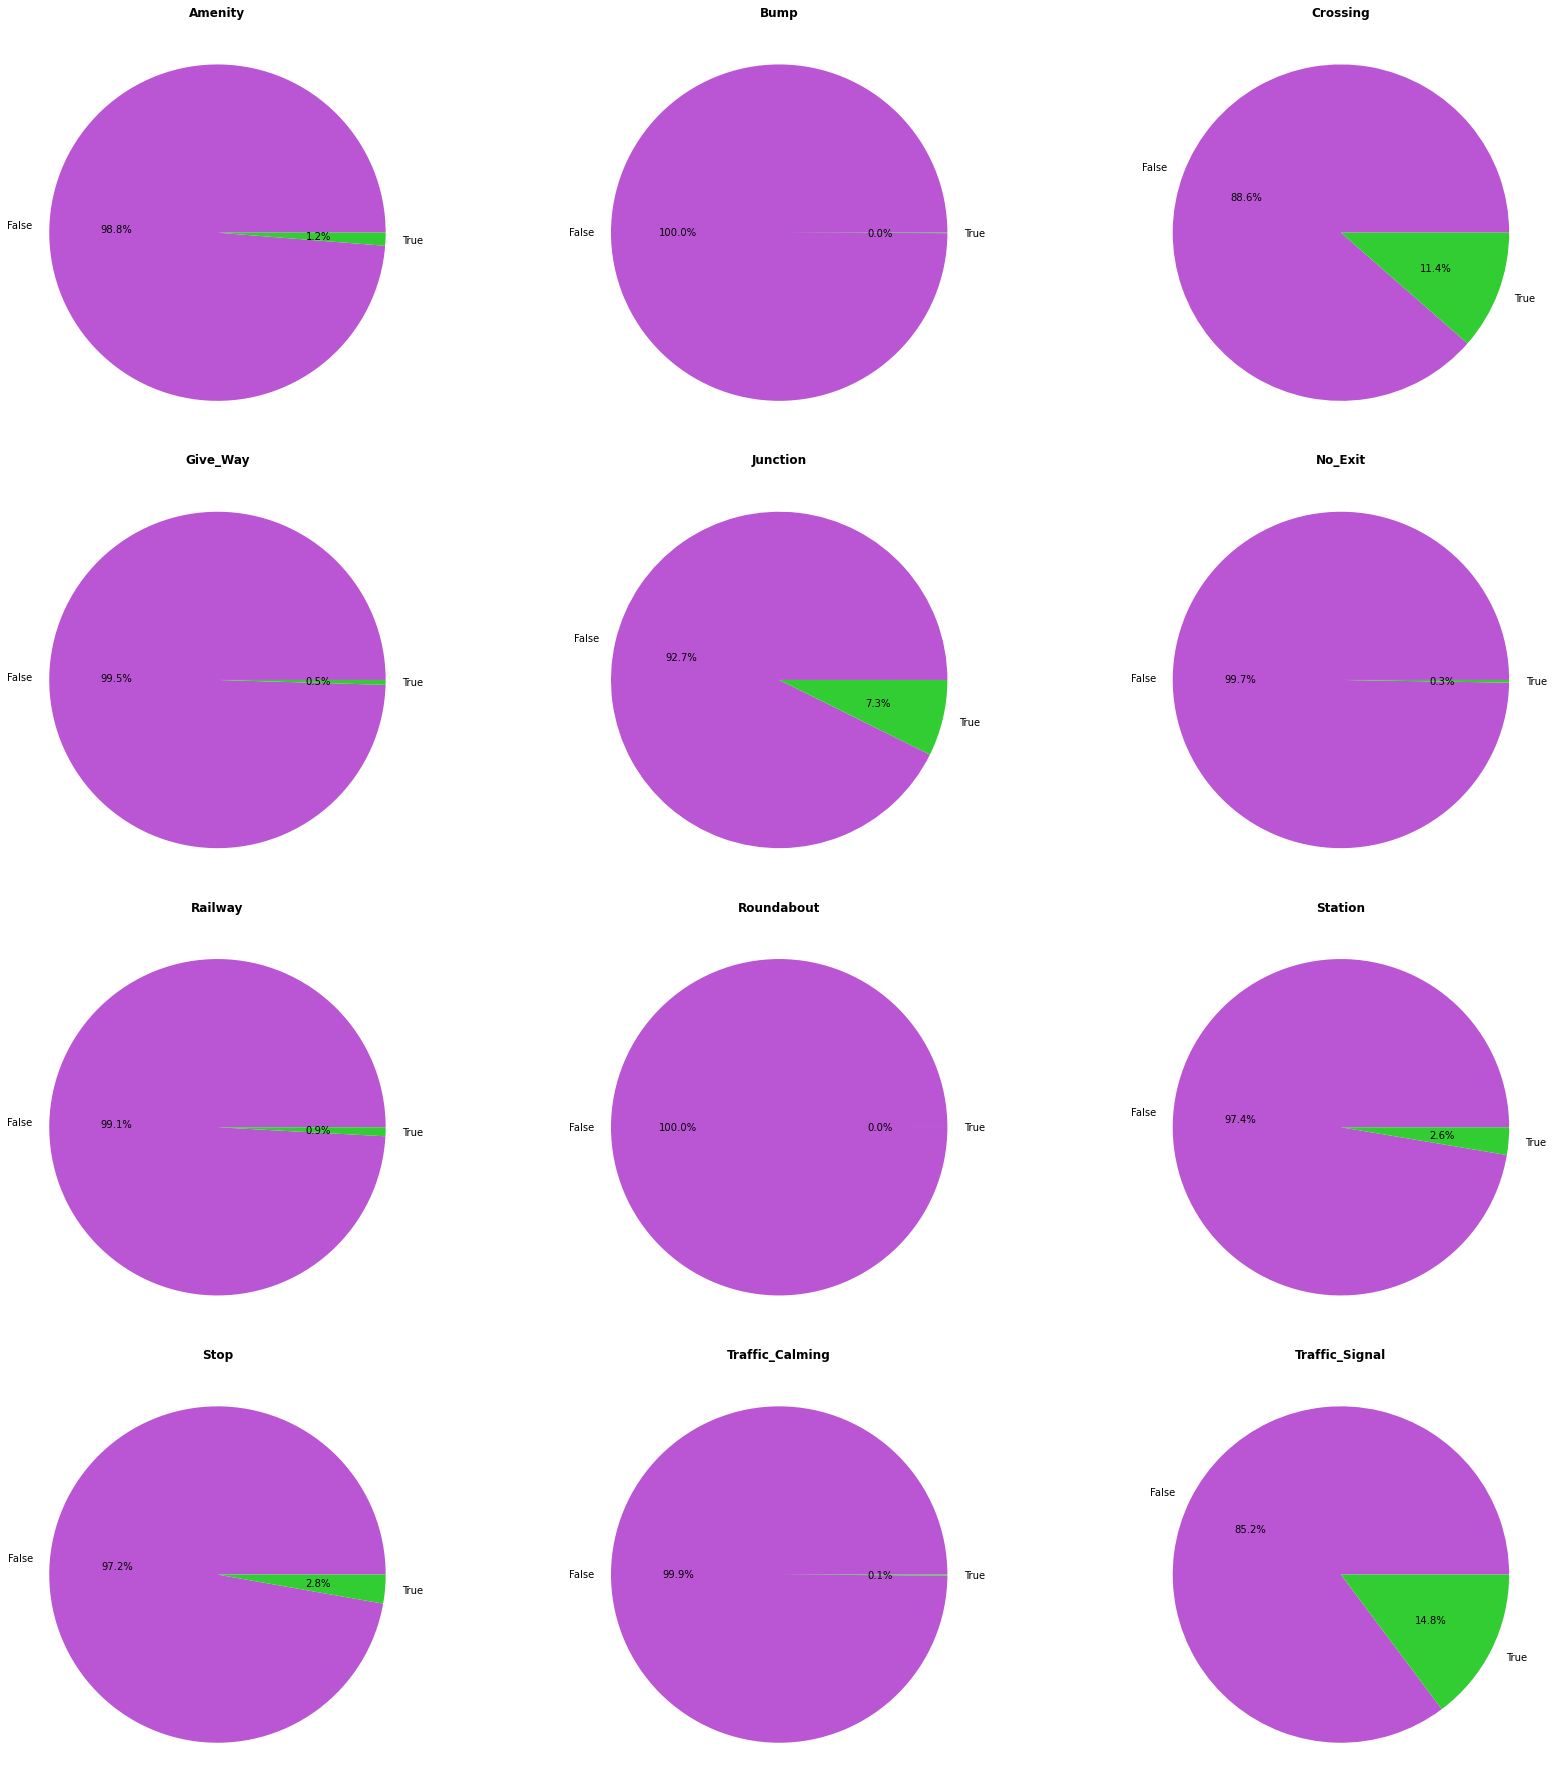

In [45]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import count

# Create a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(25, 25))

# List of columns to plot
columns = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# Calculate the count of each category for each column across all years
category_counts = []
for column in columns:
    counts = df_pyspark_clean.groupBy(column).agg(count('*').alias('count'))
    category_counts.append(counts)

# Generate pie charts for each column and place them in the corresponding subplot
for i, column in enumerate(columns):
    row = i // 3  # Calculate the row index
    col = i % 3   # Calculate the column index

    # Create a pie chart for the current column with data from all years
    ax = axes[row, col]
    labels = [str(label[column]) for label in category_counts[i].collect()]
    counts = [count['count'] for count in category_counts[i].collect()]
    ax.pie(counts, labels=labels, autopct='%1.1f%%', colors=["mediumorchid", "limegreen"])

    # Set the title for the subplot
    ax.set_title(column, fontweight="bold")

# Adjust the layout
plt.tight_layout()
plt.show()


In [16]:
## WORDCLOUD - SEVERITY4 for DESCRIPTION ###

import matplotlib as mt
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from pyspark.sql.functions import col

severity4=df_pyspark_clean[df_pyspark_clean['Severity']==4]

# Convert PySpark DataFrame to Pandas DataFrame
df = severity4.select(col("Description")).toPandas()

# Creating variable with data for this Word Cloud
text = ' '.join(df['Description'].tolist())

# Creating Mask for Word Cloud
path = '/Users/bhagyashrikadam/Documents/NEU_ASSIGNMENTS/ALY6110/Final Project/'
mask = np.array(Image.open(path + 'car.png'))
stopwords = set(STOPWORDS)


# Word Cloud Creation
wc = WordCloud(width=800, height=600, mask=mask, random_state=101, max_font_size=450,
                   min_font_size=1.5, stopwords=stopwords, background_color="white",
                   scale=3, max_words=200, collocations=False)
# Generate Word Cloud
wc.generate(str(text))

# Show
fig=plt.figure(figsize=(30,10))
plt.ylim(0,1300)
plt.xlim(0,7500)
plt.gca().invert_yaxis()
plt.axis("off")
plt.title('Accidents: Severity 4', fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.imshow(wc, interpolation='bilinear', aspect='auto')

plt.show()

ValueError: Only supported for TrueType fonts

In [19]:
## RANDOM FOREST MODEL - WORKING ##

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select the relevant columns for training
selected_cols = ['Start_Lat', 'Start_Lng', 'Temperature', 'Wind_Chill', 'Humidity', 'Pressure', 'Visibility', 'Wind_Speed', 'Severity']

# Drop rows with missing values in selected columns
dataset = df_pyspark_clean.dropna(subset=selected_cols)

# Convert string columns to numeric type
for col in selected_cols:
    dataset = dataset.withColumn(col, dataset[col].cast('double'))

# Create a vector assembler to combine the selected columns into a feature vector
assembler = VectorAssembler(inputCols=selected_cols[:-1], outputCol='features')

# Split the dataset into training and testing sets (70% for training, 30% for testing)
train_data, test_data = dataset.randomSplit([0.7, 0.3], seed=42)

# Create a Random Forest classifier
rf = RandomForestClassifier(labelCol='Severity', featuresCol='features')

# Create a pipeline to chain the vector assembler and the Random Forest classifier
pipeline = Pipeline(stages=[assembler, rsf])

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using accuracy metric
evaluator = MulticlassClassificationEvaluator(labelCol='Severity', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2%}".format(accuracy))

23/06/28 13:22:18 WARN MemoryStore: Not enough space to cache rdd_57_3 in memory! (computed 44.4 MiB so far)
23/06/28 13:22:18 WARN MemoryStore: Not enough space to cache rdd_57_5 in memory! (computed 44.4 MiB so far)
23/06/28 13:22:19 WARN BlockManager: Persisting block rdd_57_5 to disk instead.
23/06/28 13:22:19 WARN BlockManager: Persisting block rdd_57_3 to disk instead.
23/06/28 13:22:24 WARN MemoryStore: Not enough space to cache rdd_57_5 in memory! (computed 29.6 MiB so far)
23/06/28 13:22:56 WARN MemoryStore: Not enough space to cache rdd_57_14 in memory! (computed 29.6 MiB so far)
23/06/28 13:22:56 WARN BlockManager: Persisting block rdd_57_14 to disk instead.
23/06/28 13:23:05 WARN MemoryStore: Not enough space to cache rdd_57_16 in memory! (computed 12.5 MiB so far)
23/06/28 13:23:05 WARN BlockManager: Persisting block rdd_57_16 to disk instead.
23/06/28 13:23:05 WARN MemoryStore: Not enough space to cache rdd_57_17 in memory! (computed 12.5 MiB so far)
23/06/28 13:23:05 WAR

Accuracy: 84.09%
